In [1]:
#Import Libraries
import cudf as pd
import cupy as np
import os
import cv2
from cuml.ensemble import RandomForestClassifier as cuRFC
from cuml.metrics.confusion_matrix import confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Preprocessing

### 1. Loading the dataset

In [2]:
image_size = 200
# function to load the dataset and return the dataset list
labels = ['PNEUMONIA', 'NORMAL']

# returns a list called data containing elements of format [image, label]  
# where image is a [200, 200] matrix representing an image
def data_loader(data_dir):
    data = list()
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            # reading the images from the folder represented in path
            img_arr = cv2.imread(os.path.join(path, img), 0)
            # resizing the image to 200x200 for analysis
            resized_arr = cv2.resize(img_arr, (image_size, image_size))
            data.append([resized_arr, class_num]) 
    return data

In [3]:
# the data returned is a list 
# list[0] is a list of type [image, class]
# list[0][0] gives us a 2d list of 200x200 image values

val = data_loader('../input/chest-xray-pneumonia/chest_xray/val')
test = data_loader('../input/chest-xray-pneumonia/chest_xray/test')
train = data_loader('../input/chest-xray-pneumonia/chest_xray/train')

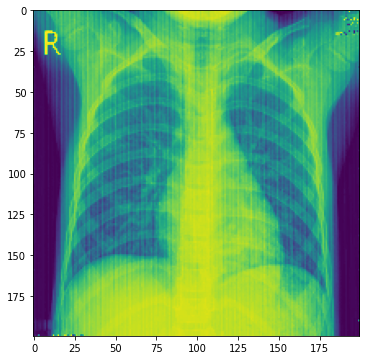

In [4]:
# displaying the stored image in the dataset
plt.figure(figsize = (6,6))
plt.imshow(np.asnumpy(train[2][0]))

### 2. Normalizing the images

In [5]:
# normalizing the values in image array for all images
def normalize_list(train):
    for pair in train:
        pair[0] = np.array(pair[0])/ 255
    return train

train = normalize_list(train)
test = normalize_list(test)
val = normalize_list(val)

In [6]:
# checking if the values were normalised properly
train[0]

[array([[0.29019608, 0.2627451 , 0.2627451 , ..., 0.62352941, 0.70196078,
         0.74901961],
        [0.25098039, 0.2       , 0.17254902, ..., 0.6627451 , 0.67058824,
         0.76078431],
        [0.23529412, 0.19607843, 0.03137255, ..., 0.61176471, 0.68627451,
         0.74901961],
        ...,
        [0.05098039, 0.05098039, 0.05098039, ..., 0.76078431, 0.76470588,
         0.75686275],
        [0.05098039, 0.05098039, 0.04705882, ..., 0.75294118, 0.76470588,
         0.77254902],
        [0.05098039, 0.05098039, 0.04705882, ..., 0.76470588, 0.76078431,
         0.77254902]]),
 0]

# Splitting the dataset

In [7]:
# iterating over the data and appending to X & Y
# converting X & Y to numpy and returning them as numpy arrays
def make_x_y(data):
    X = []
    Y = []
    for pair in data:
        X.append(pair[0])
        Y.append(pair[1])
    return np.array(X),np.array(Y)
x_train, y_train = make_x_y(train)
x_test, y_test = make_x_y(test)
x_val, y_val = make_x_y(val)

In [8]:
# checking shapes of the data
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(5216, 200, 200)
(5216,)
(624, 200, 200)
(624,)
(16, 200, 200)
(16,)


### 1. flattening / reshaping the images

In [9]:
# using reshape to flatten the images from 200*200 to 40,000 columns
x_train = x_train.reshape(len(x_train), 200*200)
x_test = x_test.reshape(len(x_test), 200*200)
x_val = x_val.reshape(len(x_val), 200*200)

print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(5216, 40000)
(624, 40000)
(16, 40000)


# Model | Random Forest Classifier

## testing the RFC model on the dataset

In [10]:
from cuml.ensemble import RandomForestClassifier as cuRFC

In [11]:
# n_estimators is number of trees in forest, 
# max_features = number of features to look at for best split 1.0 means look at all features

cuml_model = cuRFC(max_features=1.0,n_bins=8, n_estimators=40)
# making the model and fitting the training data on the model
cuml_model.fit(x_train.astype('float32'), y_train.astype('float32'))

RandomForestClassifier()

In [12]:
# using the above trained model to predict for the 
y_rfc_predict = cuml_model.predict(x_test.astype('float32'))
print(type(y_rfc_predict))
print(y_rfc_predict.shape)

<class 'cupy._core.core.ndarray'>
(624,)


## RFC model evaluation

In [13]:
# transforming the y_test matrix in the same order as of y_predict
y_test_temp = y_test.reshape(1, len(y_test))[0]
print(type(y_test_temp))
print(y_test_temp.shape)

<class 'cupy._core.core.ndarray'>
(624,)


In [14]:
# converting the results from ndarray to nparrays for evaluation
y_np_test = np.asnumpy(y_test_temp)
y_np_rfc_predict = np.asnumpy(y_rfc_predict)
print(type(y_np_test))
print(type(y_np_rfc_predict))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### 1. Accuracy of model

In [15]:
accu = accuracy_score(y_np_test, y_np_rfc_predict)
print("accuracy of model is: %f" %accu)

accuracy of model is: 0.769231


### 2. Confusion matrix

In [16]:
import seaborn as sns

confusion matrix of model: 



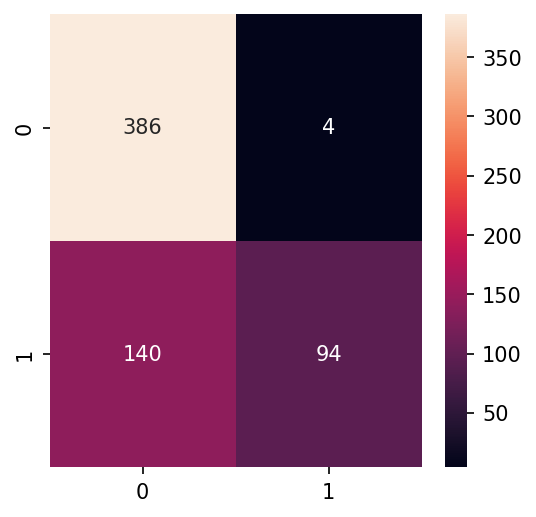

In [17]:
print("confusion matrix of model: \n")
cmap = confusion_matrix(y_np_test, y_np_rfc_predict)
plt.figure(figsize = (4, 4), dpi = 150)
hm = sns.heatmap(data=cmap,annot=True,fmt='g')

### 3. classification report of model

In [18]:
print("classification report of model: \n")
print(classification_report(y_np_test, y_np_rfc_predict, target_names = labels))

classification report of model: 

              precision    recall  f1-score   support

   PNEUMONIA       0.73      0.99      0.84       390
      NORMAL       0.96      0.40      0.57       234

    accuracy                           0.77       624
   macro avg       0.85      0.70      0.70       624
weighted avg       0.82      0.77      0.74       624



### 4. ROC curve

In [19]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

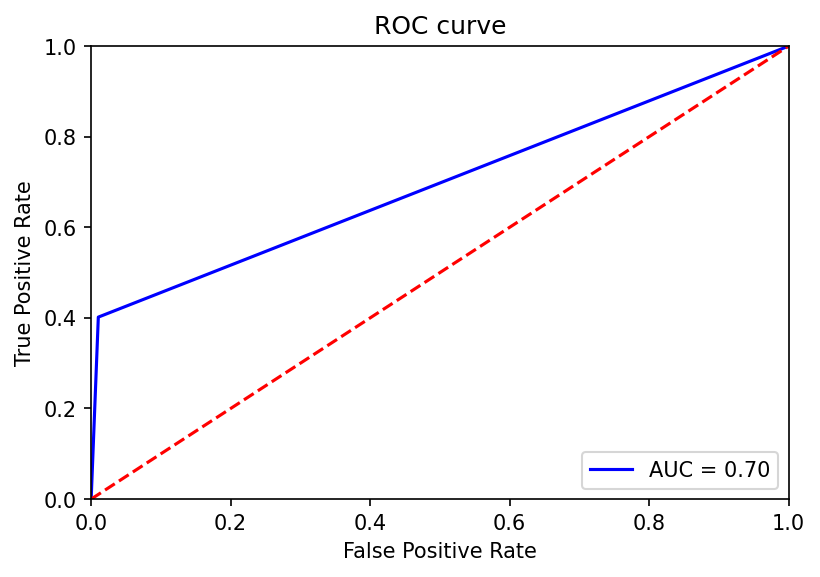

In [20]:
# plotting the ROC curve and associated metrics
pred = cuml_model.predict(x_test)
pred = np.asnumpy(pred)

fpr, tpr, threshold = metrics.roc_curve(y_np_test, pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(6, 4), dpi = 150)
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 5. All Metrics 

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

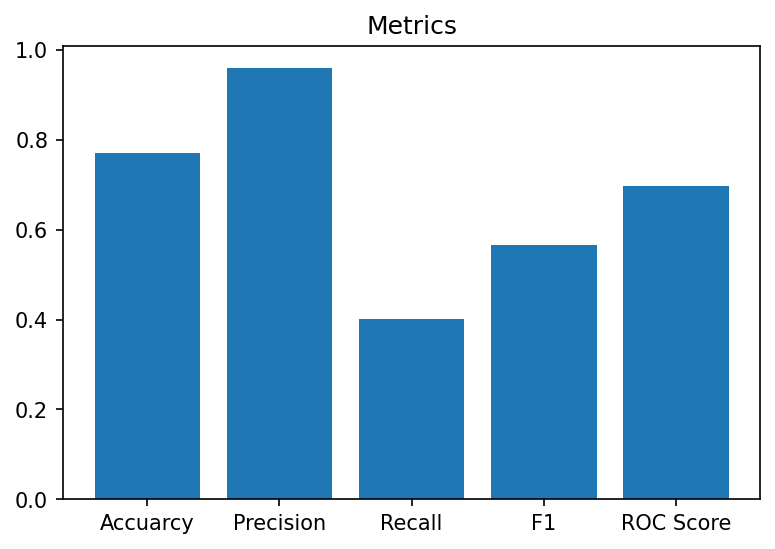

In [22]:
accuracy  = accuracy_score(y_np_test, y_np_rfc_predict)
precision  = precision_score(y_np_test, y_np_rfc_predict)
recall  = recall_score(y_np_test, y_np_rfc_predict)
f1  = f1_score(y_np_test, y_np_rfc_predict)
roc  = roc_auc_score(y_np_test, y_np_rfc_predict)

value = [accuracy, precision, recall, f1, roc]
labels = ['Accuarcy', 'Precision', 'Recall', 'F1', 'ROC Score']

plt.figure(figsize = (6, 4), dpi=150)
plt.bar(labels, value)
plt.title('Metrics')
plt.show()

### 6. model results
>  the model shows an accuracy of **76.9%** <br/>
>  we see a higher **99% recall** in case of pneumonia which is desired <br/>
>  we have a high F1 score in case of pneumonia of **84%** <br/>


### note
>  the model is not run on validation due to very few examples in the validation set therefore is not a dataset big enough to judge models performance

# Model | Convolutional Neural Network

## Data preparation

In [23]:
x_train, y_train = make_x_y(train)
x_test, y_test = make_x_y(test)
x_val, y_val = make_x_y(val)

# creating testing & training sets for CNN model

In [24]:
x_train = np.asnumpy(x_train)
y_train = np.asnumpy(y_train)

x_test = np.asnumpy(x_test)
y_test = np.asnumpy(y_test)

x_val = np.asnumpy(y_val)
y_val = np.asnumpy(y_val)

In [25]:
x_train = x_train.reshape(len(x_train), 200, 200, 1)
x_test = x_test.reshape(len(x_test), 200, 200, 1)
# reshaping the data, the 1 added specifies the data is greyscale

In [26]:
x_train.shape

(5216, 200, 200, 1)

In [27]:
from tensorflow.keras.utils import to_categorical
#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train[0]

array([1., 0.], dtype=float32)

## creating & testing of CNN model

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

In [29]:
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(200,200,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

2022-03-15 10:47:28.966344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 10:47:28.970771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 10:47:28.971394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 10:47:28.972346: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [30]:
#compiling model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

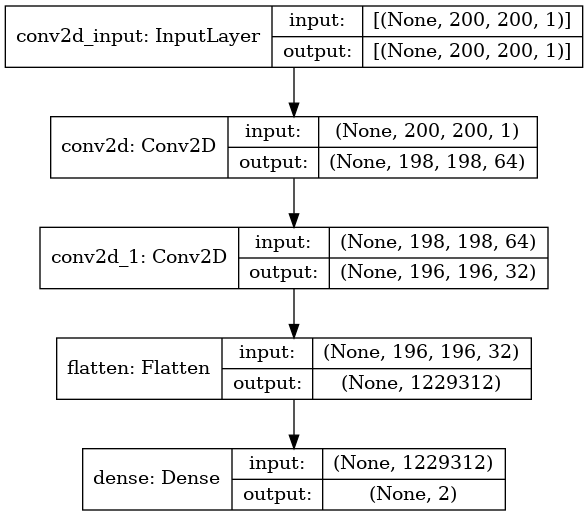

In [31]:
## plotting model architechture
from keras.utils.vis_utils import plot_model
plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

In [32]:
# fitting the model on our training data and using our testing data for validation
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3)

2022-03-15 10:47:31.157438: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 834560000 exceeds 10% of free system memory.
2022-03-15 10:47:32.017401: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 834560000 exceeds 10% of free system memory.
2022-03-15 10:47:32.627694: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3


2022-03-15 10:47:33.803661: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


163/163 [==============================] - 15s 50ms/step - loss: 0.5487 - accuracy: 0.8641 - val_loss: 0.9243 - val_accuracy: 0.7260
Epoch 2/3
163/163 [==============================] - 8s 47ms/step - loss: 0.1035 - accuracy: 0.9592 - val_loss: 1.1360 - val_accuracy: 0.6987
Epoch 3/3
163/163 [==============================] - 8s 48ms/step - loss: 0.0590 - accuracy: 0.9793 - val_loss: 0.7453 - val_accuracy: 0.7981


> we see a **96.84% accuracy** in only 3 epochs using our CNN model 

In [33]:
# predicting our whole testing dataset
y_predict_cnn = model.predict(x_test)
y_predict_cnn

array([[0.97060925, 0.02939075],
       [0.9605448 , 0.03945522],
       [0.9816805 , 0.0183195 ],
       ...,
       [0.8502303 , 0.1497697 ],
       [0.83934647, 0.16065353],
       [0.0041392 , 0.9958609 ]], dtype=float32)

In [34]:
# function to convert the encoding it did back to labels
def convert_to_label(y_predict):
    ans = []
    for pair in y_predict:
        if pair[0]>0.5:
            ans.append(0)
        else:
            ans.append(1)
    return np.asnumpy(ans)

In [35]:
y_predict_cnn = convert_to_label(y_predict_cnn)
print(len(y_predict_cnn))
print(type(y_predict_cnn))
print(y_predict_cnn)

624
<class 'numpy.ndarray'>
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1
 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0
 1 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0

In [36]:
y_test = convert_to_label(y_test)
print(len(y_test))
print(type(y_test))
print(y_test)

624
<class 'numpy.ndarray'>
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

## CNN model Evaluation

### 1. accuracy of CNN model

In [37]:
accu = accuracy_score(y_test, y_predict_cnn)
print("accuracy of model is: %f" %accu)

accuracy of model is: 0.798077


### 2. confusion matrix

confusion matrix of model: 



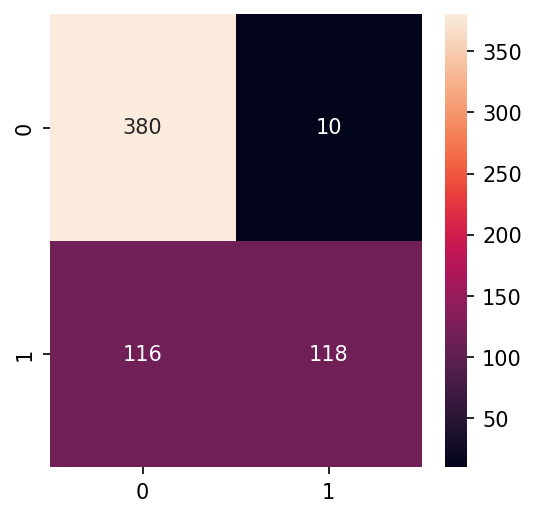

In [38]:
print("confusion matrix of model: \n")
cmap = confusion_matrix(y_test, y_predict_cnn)
plt.figure(figsize = (4, 4), dpi = 150)
hm = sns.heatmap(data=cmap,annot=True,fmt='g')

### 3. classification report for CNN

In [39]:
print("classification report of model: \n")
print(classification_report(y_test, y_predict_cnn, target_names = ['PNEUMONIA', 'NORMAL']))

classification report of model: 

              precision    recall  f1-score   support

   PNEUMONIA       0.77      0.97      0.86       390
      NORMAL       0.92      0.50      0.65       234

    accuracy                           0.80       624
   macro avg       0.84      0.74      0.75       624
weighted avg       0.82      0.80      0.78       624



### 3. ROC curve

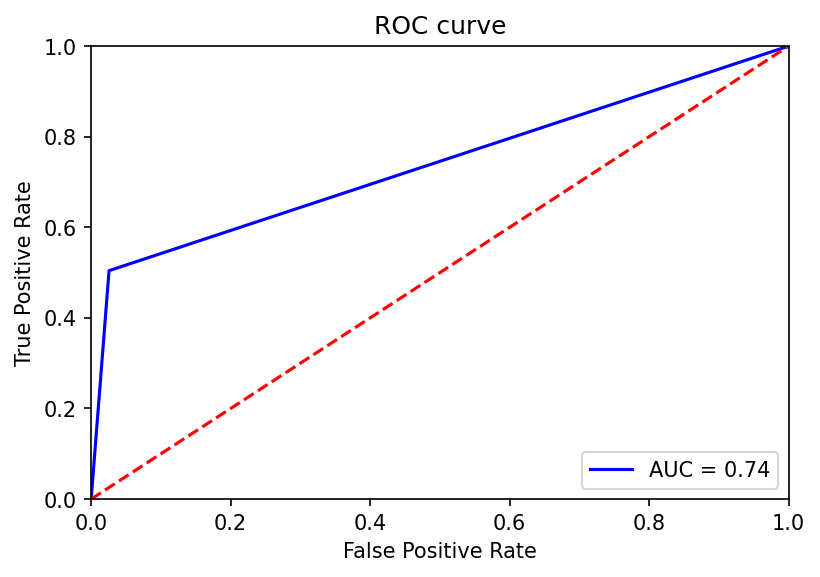

In [40]:
# plotting the ROC curve and associated metrics
pred = model.predict(x_test)
pred = convert_to_label(pred)
pred = np.asnumpy(pred)

fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(6, 4), dpi = 150)
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 5. all metrics

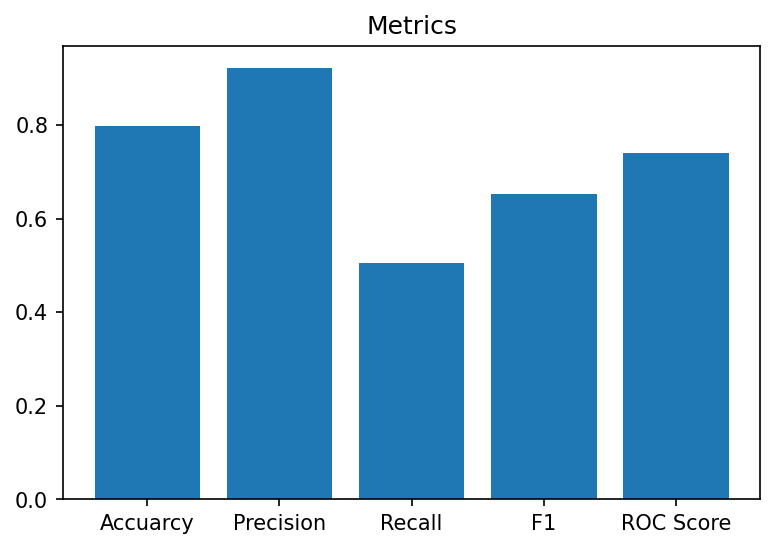

In [41]:
accuracy  = accuracy_score(y_test, y_predict_cnn)
precision  = precision_score(y_test, y_predict_cnn)
recall  = recall_score(y_test, y_predict_cnn)
f1  = f1_score(y_test, y_predict_cnn)
roc  = roc_auc_score(y_test, y_predict_cnn)

value = [accuracy, precision, recall, f1, roc]
labels = ['Accuarcy', 'Precision', 'Recall', 'F1', 'ROC Score']

plt.figure(figsize = (6, 4), dpi=150)
plt.bar(labels, value)
plt.title('Metrics')
plt.show()

### 6. CNN model results
>  the model shows an accuracy of **71.4%** in my run <br/>
>  we see a high **99% recall** in case of pneumonia which is desired <br/>
>  we have a high F1 score in case of pneumonia of **81%** <br/>

### note
>  the model is not run on validation due to very few examples in the validation set therefore is not a dataset big enough to judge models performance